In [ ]:
#| default_exp fastspeech_train

# Fastspeech Training

In [ ]:
#| export
from tts_0.fastspeech import FastSpeech
from tts_0.tts_data import TTSDataset, collate_fn
from torch.utils.data import DataLoader
from functools import partial
from tts_0.data import *

/Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <7702F607-92FA-3D67-9D09-0710D936B85A> /Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <1E9FA061-EA31-3736-81D0-79A33B965097> /Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
#| export
import torch.nn as nn
from tts_0.learn import *
from typing import Callable, Sequence
from torch.nn import Module
from torch import optim
import torch.nn.functional as F
import fastcore.all as fc
from torch import tensor
from torch.optim.lr_scheduler import OneCycleLR
import torch
from fastspeech.visualize import show_mel

In [ ]:
#| export
class TrainFastSpeech(Learner):
    def __init__(self, model: Module, dls: DataLoaders, loss_fn: Callable, loss_fn_b: Callable, lr: float = 0.1, 
                 cbs: Sequence[Callback] = (), optimizer_fn: Callable = optim.SGD) -> None:
        super().__init__(model, dls, loss_fn, lr, cbs, optimizer_fn)
        self.loss_fn_b = loss_fn_b
        
    def predict(self) -> None:
        phones, durations = self.batch[:2]

        self.preds = self.model(phones, durations)
    
    def get_loss(self) -> None:
        d_slice = (slice(None), slice(None, -1))
        durations, mels, mel_alignment, duration_alignment = self.batch[1:]
        bs = mels.shape[0]
        
        self.loss, self.duration_loss = tensor(0.), tensor(0.)
        for i in range(bs):
            mel_slice = (slice(None), slice(None, mel_alignment[i]))
            duration_slice = slice(None, duration_alignment[i])
            
            self.loss += self.loss_fn(self.preds[0][i][mel_slice], mels[i][mel_slice]) / bs
            self.duration_loss += self.loss_fn_b(self.preds[1][i][duration_slice], 
                                                 durations[i][duration_slice].to(torch.float)) / bs
    
    def backward(self) -> None:
        self.loss.backward()
        self.duration_loss.backward()
    
    def step(self) -> None:
        self.optimizer.step()
    
    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [ ]:
#| export
class ScheduleLR(Callback):
    def __init__(self, Scheduler, *args, **kwargs):
        super().__init__()
        self.Scheduler = Scheduler
        self.args = args
        self.kwargs = kwargs
        
    def before_fit(self, learn):
        learn.scheduler = self.Scheduler(learn.optimizer, *self.args, **self.kwargs)
        
    def after_batch(self, learn):
        learn.scheduler.step()

In [ ]:
#| export
class ShowMelCB(Callback):
    def __init__(self, xb, n_steps=500):
        super().__init__()
        fc.store_attr()
        self.i = 0
    
    def _show_mel(self):
        with torch.no_grad():
            phones, durations = self.xb[:2]

            mel, _ = learn.model(phones, durations)
        
        show_mel(to_cpu(mel)[0])
        
    def after_batch(self, learn):
        if self.i % self.n_steps == 0:
            self._show_mel()
        self.i += 1

In [ ]:
#| export
class Hook:
    def __init__(self, module: Module, func: Callable) -> None:
        self.hook = module.register_forward_hook(partial(func, self))
    
    def __del__(self):
        self.remove()
        
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
    
    def remove(self):
        self.hook.remove()

In [ ]:
#| export
def count_parameters(model):
    return sum([param.numel() for param in list(model.parameters())])

In [ ]:
#| hide
path = '../../data/LJSpeech-1.1/wavs/'
path_vocab = '../../fastspeech/sample_data/cmudict-0.7b.symbols.txt'

In [ ]:
#| hide
sample_rate = 22050
hop_length = 256
n_bins = 80
n_fft = 1024

In [ ]:
ds = TTSDataset(path, path_vocab, sample_rate, n_fft, hop_length, n_bins)

  0%|          | 0/13082 [00:00<?, ?it/s]

In [ ]:
#| hide
batch_size = 12
n_workers = 0
persistent_workers = False

In [ ]:
dl = DataLoader(ds, 
                batch_size, 
                shuffle=True, 
                collate_fn=partial(collate_fn, pad_num=ds.vocab.pad_num))

In [ ]:
#| hide
xb = next(iter(dl))
dls = DataLoaders(dl, [])

In [ ]:
config = dict(
    embedding_size = len(ds.vocab),
    hidden_channels = 256,
    filter_channels = 1024,
    out_channels = n_bins,
    ks = 3,
    n_heads = 2,
    n_hidden = 0,
    p_dropout = 0.1,
    n_encoders = 4,
    n_decoder = 4,
    Activation = nn.ReLU,
    init_fn = partial(nn.init.kaiming_normal_, nonlinearity='relu'),
    device = None
)

In [ ]:
#| hide
n_epochs = 1
n_batches = len(dls.train)
n_steps = n_batches * n_epochs
n_steps

1091

In [ ]:
model = FastSpeech(**config)
count_parameters(model)

16320001

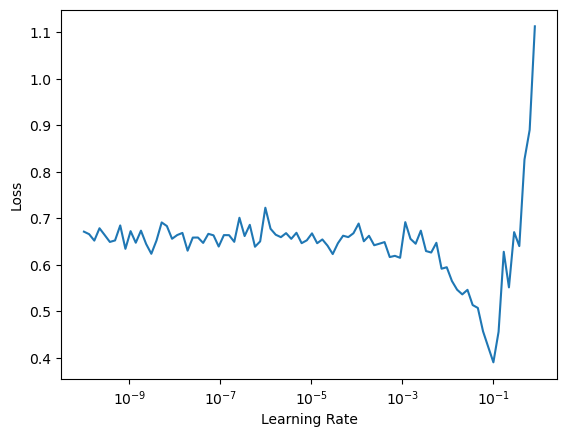

In [ ]:
TrainFastSpeech(model, dls, F.l1_loss, F.mse_loss, cbs=[]).lr_find(start_lr=1e-10)

In [ ]:
max_lr = 7e-2

cbs = [ScheduleLR(OneCycleLR, max_lr, n_steps), MetricsCB(), ProgressCB(True), ShowMelCB(xb)]
learn = TrainFastSpeech(model, dls, F.l1_loss, F.mse_loss, lr=max_lr, cbs=cbs)
learn.fit(n_epochs, valid=False)